<a href="https://colab.research.google.com/github/megasiska86/Neural-Network-Repository/blob/master/Mobilenetv2_scheduler(step_cyclic).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
629abc0f9a73c2897383a9178e8e38f7141be30d
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [0]:
!rm -rf fashion-mnist-master.zip

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt


plt.ion()   # interactive mode

In [0]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ColorJitter(), transforms.Grayscale(num_output_channels=3),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=True, transform=transform,
                                        download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=False, transform=transform,
                                       download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=0)
trainset1,validset = torch.utils.data.random_split(trainset, [50000,10000])
trainloader1=torch.utils.data.DataLoader(trainset1, batch_size=8,shuffle=True, num_workers=0)
validloader=torch.utils.data.DataLoader(validset, batch_size=8,shuffle=True, num_workers=0)

classes = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
torch.save({'trainset1': trainset1, 'validset': validset,'trainloader1': trainloader1, 'validloader': validloader,'testset': testset, 'testloader':testloader}, 'dataset.pth')

In [0]:
checkpoint = torch.load('dataset.pth')
trainset1 = checkpoint['trainset1']
validset = checkpoint['validset']
trainloader1 = checkpoint['trainloader1']
validloader =checkpoint['validloader']
testset = checkpoint['testset']
testloader =checkpoint['testloader']

In [0]:
#!cp '/content/dataset.pth' '/content/drive/My Drive/dataset.pth'

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
model=models.mobilenet_v2(pretrained=True)
model.classifier[1]=nn.Linear(1280,10)
model=model.to(device)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_

#scheduler stepLR stepsize=5, gamma=0.1

In [0]:
optimizer=optim.SGD(model.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [0]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
train_acc_list=[]
test_acc_list=[]
start_epoch=0
e=5

In [0]:
for epoch in range(start_epoch,25):
    #exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 200) % (200 * 200) == 0:
            print(i*10, '/ 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
    correct_te = 0
    total_te = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            _, predicted_v = torch.max(outputs.data, 1)
            correct_te += (predicted_v == labels).sum().item()
            total_te += labels.size(0)
    accuracy_te = 100*correct_te/total_te
    test_acc_list.append(accuracy_te)
                
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses.append(m_t_l)
    mean_valid_losses.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list.append(accuracy_v)
    train_acc_list.append(accuracy_t)
    
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'train loss': mean_train_losses,'train acc': train_acc_list, 'valid loss':mean_valid_losses, 'valid acc': valid_acc_list}, 'mo.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f}% valid loss : {:.4f}, valid acc : {:.2f}%, test acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v, accuracy_te))
print('best val acc: {0}, best train loss: {1}, test acc mean: {2}'.format(np.max(valid_acc_list),np.min(mean_train_losses),np.mean(test_acc_list)))

0 / 50000
2000 / 50000
epoch : 1, train loss : 0.8859, train acc : 67.52% valid loss : 0.3481, valid acc : 87.09%, test acc : 87.21%
0 / 50000
2000 / 50000
epoch : 2, train loss : 0.2872, train acc : 89.45% valid loss : 0.3371, valid acc : 87.71%, test acc : 87.65%
0 / 50000
2000 / 50000
epoch : 3, train loss : 0.2338, train acc : 91.40% valid loss : 0.2442, valid acc : 91.20%, test acc : 91.22%
0 / 50000
2000 / 50000
epoch : 4, train loss : 0.2056, train acc : 92.45% valid loss : 0.2382, valid acc : 91.24%, test acc : 91.20%
0 / 50000
2000 / 50000
epoch : 5, train loss : 0.1903, train acc : 92.95% valid loss : 0.2385, valid acc : 91.13%, test acc : 91.31%
0 / 50000
2000 / 50000
epoch : 6, train loss : 0.1719, train acc : 93.64% valid loss : 0.2184, valid acc : 92.22%, test acc : 92.27%
0 / 50000
2000 / 50000
epoch : 7, train loss : 0.1588, train acc : 94.20% valid loss : 0.2317, valid acc : 91.44%, test acc : 91.65%
0 / 50000
2000 / 50000
epoch : 8, train loss : 0.1506, train acc : 94

In [0]:
checkpoint = torch.load('mo.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
mean_train_losses = checkpoint['train loss']
train_acc_list=checkpoint['train acc']
mean_valid_losses = checkpoint['valid loss']
valid_acc_list=checkpoint['valid acc']

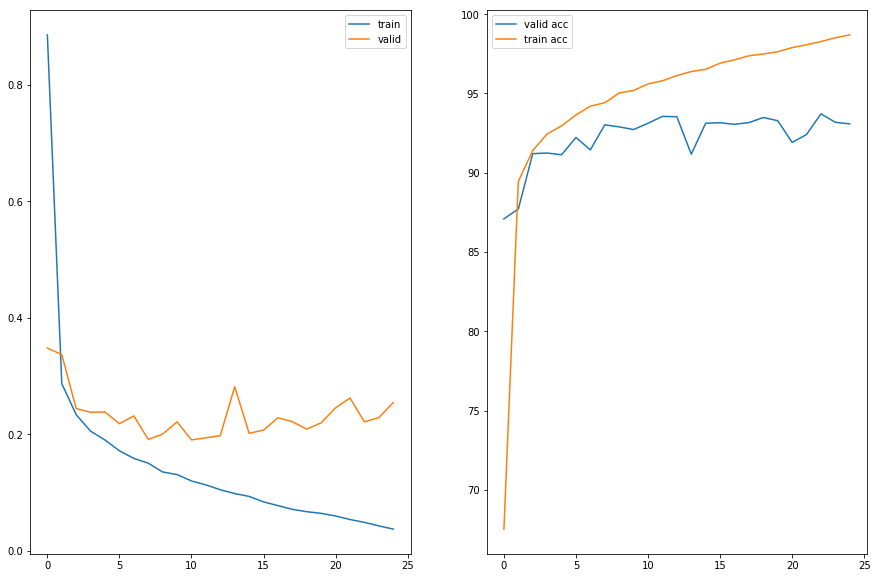

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list, label='valid acc')
ax2.plot(train_acc_list, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/mo.pth' '/content/drive/My Drive/Colab Notebooks/mo.pth'

In [0]:
!cp '/content/mo1.pth' '/content/drive/My Drive/Colab Notebooks/mo1.pth'

In [0]:
!cp '/content/mo2.pth' '/content/drive/My Drive/Colab Notebooks/mo2.pth'

#scheduler mulai dari epoch ke-6

In [0]:
optimizer1=optim.SGD(model.parameters(), lr=0.0001)
#optimizer1 = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn1 = nn.CrossEntropyLoss()
#loss_fn1 = nn.NLLLoss()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.1)

In [0]:
mean_train_losses1 = []
mean_valid_losses1 = []
valid_acc_list1 = []
train_acc_list1=[]
test_acc_list1=[]
start_epoch1=0
e1=5
val_acc_i=[]
train_acc_i=[]

In [0]:
for epoch in range(start_epoch1,40):
    if epoch>5:
        scheduler = lr_scheduler.CyclicLR(optimizer1, base_lr=0.0001, max_lr=0.0006, step_size_up=9000)
        scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer1.zero_grad()
        
        outputs = model(images)
        loss = loss_fn1(outputs, labels)
        loss.backward()
        optimizer1.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        train_acc_i.append(correct_t/total_t)
        if (i * 2000) % (2000 * 2000) == 0:
            print(i*10, '/ 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn1(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
            val_acc_i.append(correct_v/total_v)
                
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses1.append(m_t_l)
    mean_valid_losses1.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list1.append(accuracy_v)
    train_acc_list1.append(accuracy_t)
    
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer1.state_dict(), 'train loss': mean_train_losses1,'train acc': train_acc_list1, 'valid loss':mean_valid_losses1, 'valid acc': valid_acc_list1}, 'mo1.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f}% valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
b_val_acc1=np.max(valid_acc_list1)
b_val_loss1=np.min(mean_valid_losses1)
b_train_acc1=np.max(train_acc_list1)
b_train_loss1=np.min(mean_train_losses1)
torch.save({'best val acc':b_val_acc1,'best val loss':b_val_loss1,'best train acc':b_train_acc1,'best train loss':b_train_loss1},'bestm.pth')
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list1),np.min(mean_train_losses1)))

0 / 50000
20000 / 50000
40000 / 50000
60000 / 50000
epoch : 31, train loss : 0.1054, train acc : 96.10% valid loss : 0.2443, valid acc : 92.21%
0 / 50000
20000 / 50000
40000 / 50000
60000 / 50000
epoch : 32, train loss : 0.1058, train acc : 95.95% valid loss : 0.2701, valid acc : 91.91%
0 / 50000
20000 / 50000
40000 / 50000
60000 / 50000
epoch : 33, train loss : 0.0993, train acc : 96.33% valid loss : 0.2698, valid acc : 91.65%
0 / 50000
20000 / 50000
40000 / 50000
60000 / 50000
epoch : 34, train loss : 0.0980, train acc : 96.20% valid loss : 0.2736, valid acc : 91.91%
0 / 50000
20000 / 50000
40000 / 50000
60000 / 50000
epoch : 35, train loss : 0.0946, train acc : 96.39% valid loss : 0.2501, valid acc : 92.32%
0 / 50000
20000 / 50000
40000 / 50000
60000 / 50000
epoch : 36, train loss : 0.0905, train acc : 96.64% valid loss : 0.2610, valid acc : 92.27%
0 / 50000
20000 / 50000
40000 / 50000
60000 / 50000
epoch : 37, train loss : 0.0888, train acc : 96.73% valid loss : 0.2754, valid acc :

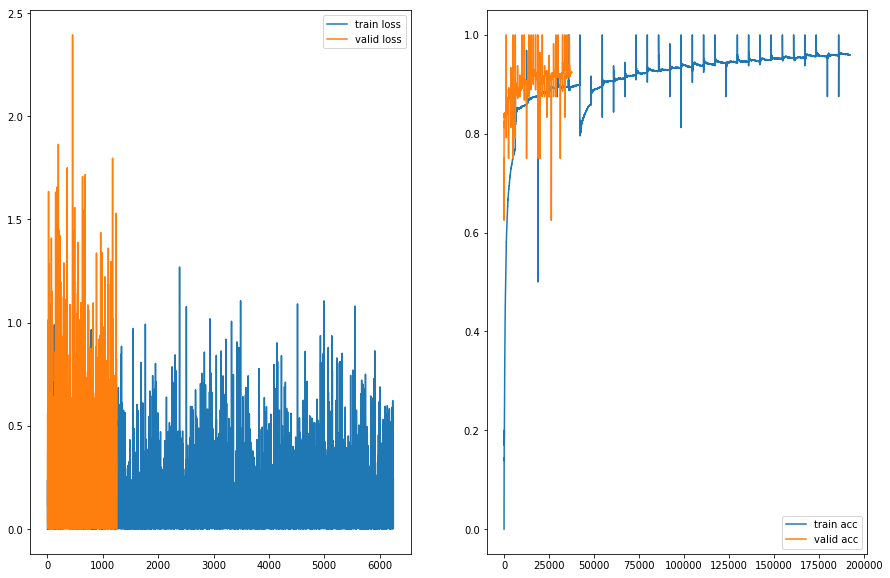

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(train_losses, label='train loss')
ax1.plot(valid_losses, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(train_acc_i, label='train acc')
ax2.plot(val_acc_i, label='valid acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

In [0]:
checkpoint = torch.load('mo1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer1.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch1 = checkpoint['epoch']
mean_train_losses1 = checkpoint['train loss']
train_acc_list1=checkpoint['train acc']
mean_valid_losses1 = checkpoint['valid loss']
valid_acc_list1=checkpoint['valid acc']

In [0]:
#!cp '/content/drive/My Drive/mo1.pth' '/content/mo1.pth'

In [0]:
checkpoint = torch.load('bestm.pth')
b_val_acc1=checkpoint['best val acc']
b_val_loss1=checkpoint['best val loss']
b_train_acc1=checkpoint['best train acc']
b_train_loss1=checkpoint['best train loss']

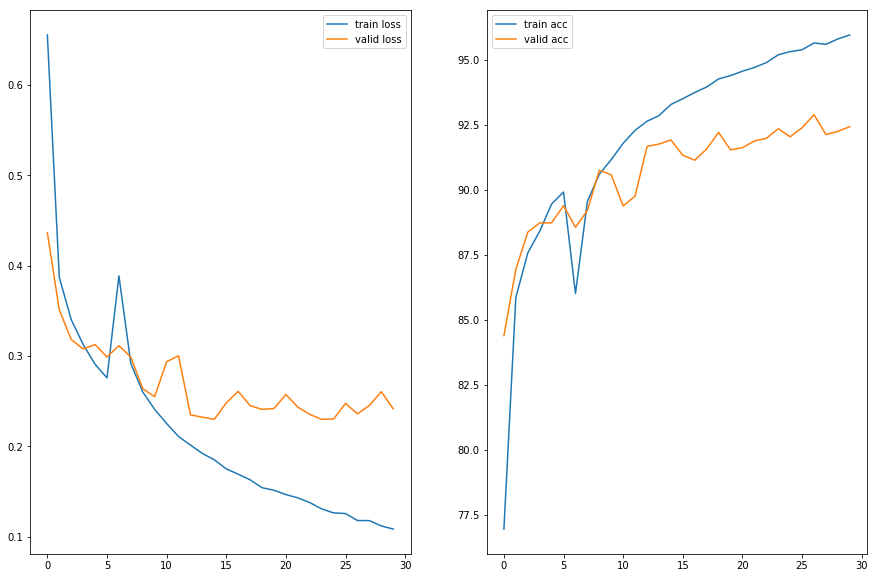

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses1, label='train loss')
ax1.plot(mean_valid_losses1, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(train_acc_list1, label='train acc')
ax2.plot(valid_acc_list1, label='valid acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

In [0]:
correct_te = 0
total_te = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted_v = torch.max(outputs.data, 1)
        correct_te += (predicted_v == labels).sum().item()
        total_te += labels.size(0)
accuracy_te = 100*correct_te/total_te
print(accuracy_te)

92.16


#scheduler di depan

In [0]:
!cp '/content/drive/My Drive/mo2.pth' '/content/mo2.pth'

In [0]:
optimizer2=optim.SGD(model.parameters(), lr=0.001)
#optimizer1 = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn2 = nn.CrossEntropyLoss()
#scheduler2 = lr_scheduler.CyclicLR(optimizer1, base_lr=0.0001, max_lr=0.0006, step_size_up=18750)
scheduler2 = lr_scheduler.CyclicLR(optimizer1, base_lr=0.001, max_lr=0.006, step_size_up=12500)

In [0]:
mean_train_losses2 = []
mean_valid_losses2 = []
valid_acc_list2 = []
train_acc_list2=[]
test_acc_list2=[]
start_epoch2=0
e2=5

In [0]:
for epoch in range(start_epoch2,25):
    scheduler2.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer2.zero_grad()
        
        outputs = model(images)
        loss = loss_fn2(outputs, labels)
        loss.backward()
        optimizer2.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 2100) % (2100 * 2100) == 0:
            print(i*10, '/ 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn2(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
                
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses2.append(m_t_l)
    mean_valid_losses2.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list2.append(accuracy_v)
    train_acc_list2.append(accuracy_t)
    
    
        #save
    #torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer2.state_dict(), 'train loss': mean_train_losses2,'train acc': train_acc_list2, 'valid loss':mean_valid_losses2, 'valid acc': valid_acc_list2}, 'mo2.pth')
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer2.state_dict(), 'train loss': mean_train_losses2,'train acc': train_acc_list2, 'valid loss':mean_valid_losses2, 'valid acc': valid_acc_list2}, 'mo3.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f}% valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
b_val_acc2=np.max(valid_acc_list2)
b_val_loss2=np.min(mean_valid_losses2)
b_train_acc2=np.max(train_acc_list2)
b_train_loss2=np.min(mean_train_losses2)
#torch.save({'best val acc':b_val_acc2,'best val loss':b_val_loss2,'best train acc':b_train_acc2,'best train loss':b_train_loss2},'bestm2.pth')
torch.save({'best val acc':b_val_acc2,'best val loss':b_val_loss2,'best train acc':b_train_acc2,'best train loss':b_train_loss2},'bestm3.pth')
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list2),np.min(mean_train_losses2)))

0 / 50000
21000 / 50000
42000 / 50000
epoch : 21, train loss : 0.0448, train acc : 98.33% valid loss : 0.3289, valid acc : 92.22%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 22, train loss : 0.0505, train acc : 98.15% valid loss : 0.3553, valid acc : 91.72%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 23, train loss : 0.0502, train acc : 98.15% valid loss : 0.3352, valid acc : 92.11%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 24, train loss : 0.0402, train acc : 98.54% valid loss : 0.3444, valid acc : 92.30%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 25, train loss : 0.0435, train acc : 98.39% valid loss : 0.3165, valid acc : 92.52%
best val acc: 92.67, best train loss: 0.040218893885612485


In [0]:
#checkpoint = torch.load('mo2.pth')
checkpoint = torch.load('mo3.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch2 = checkpoint['epoch']
mean_train_losses2 = checkpoint['train loss']
train_acc_list2=checkpoint['train acc']
mean_valid_losses2 = checkpoint['valid loss']
valid_acc_list2=checkpoint['valid acc']

In [0]:
#checkpoint = torch.load('bestm2.pth')
checkpoint = torch.load('bestm3.pth')
b_val_acc2=checkpoint['best val acc']
b_val_loss2=checkpoint['best val loss']
b_train_acc2=checkpoint['best train acc']
b_train_loss2=checkpoint['best train loss']

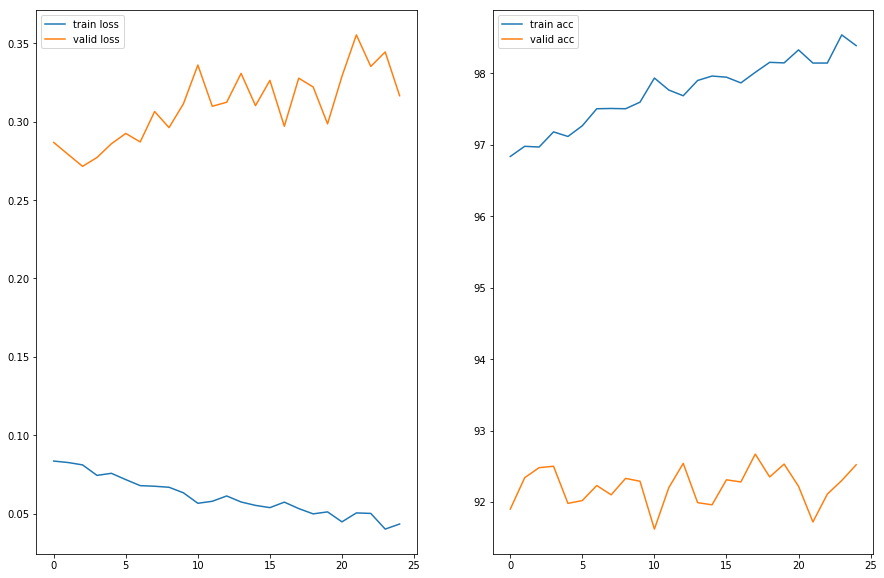

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses2, label='train loss')
ax1.plot(mean_valid_losses2, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(train_acc_list2, label='train acc')
ax2.plot(valid_acc_list2, label='valid acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

In [0]:
correct_te = 0
total_te = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted_v = torch.max(outputs.data, 1)
        correct_te += (predicted_v == labels).sum().item()
        total_te += labels.size(0)
accuracy_te = 100*correct_te/total_te
print(accuracy_te)

92.62


In [0]:
!cp '/content/mo3.pth' '/content/drive/My Drive/mo3.pth'

In [0]:
!cp '/content/mo1.pth' '/content/drive/My Drive/mo1.pth'

In [0]:
!cp '/content/mo2.pth' '/content/drive/My Drive/mo2.pth'

In [0]:
!cp '/content/dataset.pth' '/content/drive/My Drive/dataset.pth'

In [0]:
!cp '/content/bestm.pth' '/content/drive/My Drive/bestm.pth'

In [0]:
!cp '/content/bestm2.pth' '/content/drive/My Drive/bestm2.pth'

In [0]:
!cp '/content/bestm3.pth' '/content/drive/My Drive/bestm3.pth'